In [1]:
# !pip install nltk
# !pip install tensorflow
# !pip install WordCloud

In [3]:
# import dependencies
import pandas as pd
import numpy as np
import csv
import os

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')


C:\Users\Mohammad\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Mohammad\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


## Importing Data

In [7]:
#fake_news_df = pd.read_csv(r"C:\Users\Mohammad\Downloads\archive (8)\fake_news.csv")
fake_news_df = pd.read_csv("Input Resource/fake_news.csv")
display(fake_news_df)

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


## Data Cleaning

In [4]:
# check missing values in dataset
fake_news_df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
# replace NaN values in 'title' and 'text'. 
fake_news_df['title'].fillna("", inplace=True)
fake_news_df['text'].fillna("", inplace=True)

**NaN Values:** When dealing with machine learning tasks, especially those that involve text, it's crucial to address missing values. If left unhandled, they can lead to errors during the modeling process or during feature extraction.

In [9]:
# combine 'title' and 'text' into a one single variable
fake_news_df['content'] = fake_news_df['title'] + ' ' + fake_news_df['text']
fake_news_df.head()

,id,title,author,text,label,content
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


We've decided to fill NaN values in the 'title' and 'text' columns with an empty string (" ") which is a common practice in text-based tasks. An empty string ensures that any text processing (e.g., tokenization or vectorization) will not encounter errors when it operates on these columns.

In [10]:
# drop unnecessary column
fake_news_df.drop(["id", "author"],axis=1,inplace=True)

# Class Imbalance check

**Balanced Classes:** It's important to check the balance of the labels in classification tasks. If there's a significant class imbalance, it can lead to biased models. A model trained on imbalanced data might predict the majority class more often, leading to misleadingly high accuracy but poor generalization to new data.

1    10413
0    10387
Name: label, dtype: int64


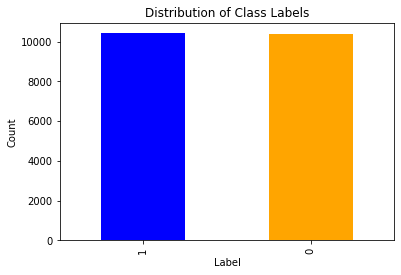

In [8]:
# check the distribution of the class labels
label_count = fake_news_df["label"].value_counts()
print(label_count)

label_count.plot(kind='bar', color=['blue','orange'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In our case, having 10,413 samples labeled as '1' (fake news) and 10,387 samples labeled as '0' (true news) suggests that the dataset is well balanced. This balance will likely aid the model in learning both classes effectively.

## EDA Processing 

### Text Length Distribution by Label


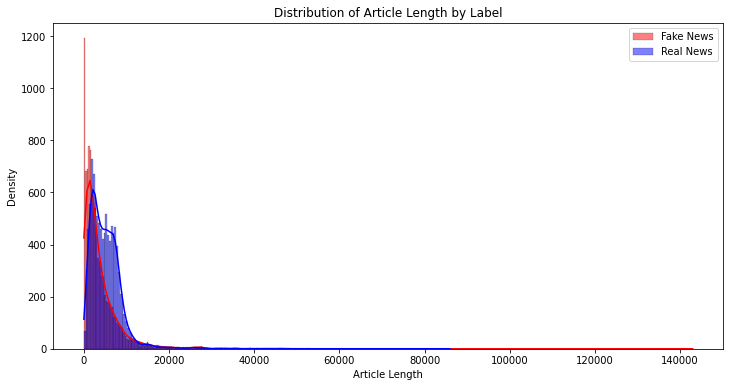

In [8]:
fake_news_df['total_length'] = fake_news_df['text'].apply(len)

# create separate dataframes for fake and real news
fake_news = fake_news_df[fake_news_df['label']==1]
real_news = fake_news_df[fake_news_df['label']==0]

# plot the distribution of article length for each label
plt.figure(figsize=(12,6))
sns.histplot(fake_news['total_length'], color='red', kde=True, label='Fake News')
sns.histplot(real_news['total_length'], color='blue', kde=True, label='Real News')
plt.title('Distribution of Article Length by Label')
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
plt.show()

We conducted an article length distribution analysis to examine potential correlations between the length of news articles and their authenticity. Our primary goal was to determine if there were discernible patterns in article length that could aid in distinguishing fake news from true news. The results revealed that the majority of news articles are clustered within the 0 to 20,000-length range. However, this distribution did not provide a clear distinction between fake and true news based on length alone. For instance, had we observed that the majority of fake news articles were significantly shorter than true news articles, we could have inferred that fake news tends to be brief. Given these findings, we recognized the need to explore additional analytical approaches, including machine learning and further visualizations, to better understand and differentiate between fake and true news.

## Bigrams Analysis


Bigram analysis refers to the study and use of pairs of words that occur adjacent to each other in a text or corpus. Essentially, a bigram is a sequence of two adjacent elements from a string of tokens, which are typically letters, syllables, or words. Bigram analysis is a type of n-gram analysis, where "n" is a number indicating the consecutive sequence length. In the case of bigrams, n=2.

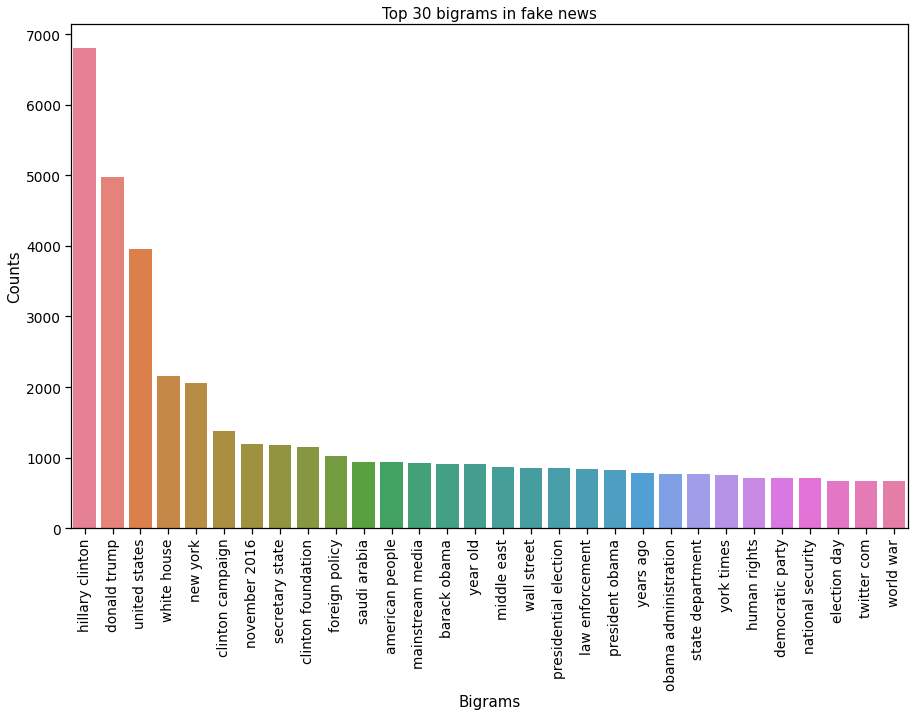

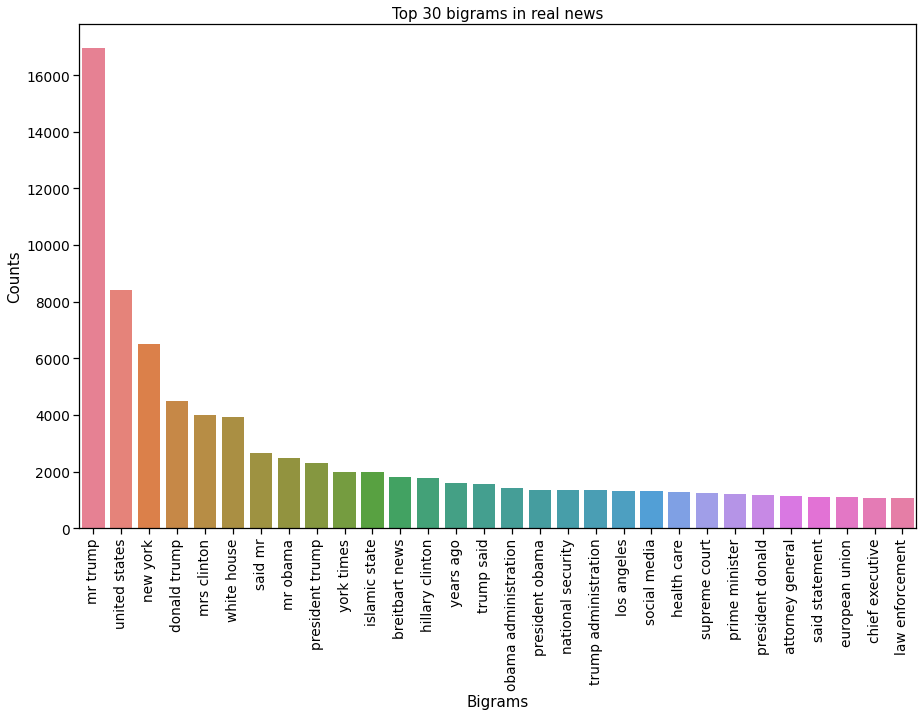

In [51]:
# Function to plot top n bigrams
def plot_top_n_bigrams(n, text, title):
    count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words='english')
    count_data = count_vectorizer.fit_transform(text)

    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in count_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Bigrams')
    plt.ylabel('Counts')
    plt.show()

# Plot top n bigrams for fake and real news
plot_top_n_bigrams(30, fake_news['text'], 'Top 30 bigrams in fake news')
plot_top_n_bigrams(30, real_news['text'], 'Top 30 bigrams in real news')


In our study of the top pairs of words, or bigrams, in both fake and real news, we found something interesting: both types of news often talked about the same things. Words like "hillary clinton", "donald trump", "united states", "white house", "campaign", and "november" popped up a lot in both datasets. This tells us that fake and real news stories during this time were focused on similar big topics, especially related to U.S. politics. However, just because an article mentions these terms doesn't mean it's true or false. The fact that both fake and real news discuss the same topics means we need to look at other ways to figure out if a story is trustworthy or not. It's a reminder that checking the facts and sources is crucial.

## TF-IDF Analysis


**TF-IDF** stands for Term Frequency-Inverse Document Frequency. It's a method used in text analysis and natural language processing to understand the importance of a word in a document relative to a collection of documents, often referred to as a corpus.

**Term Frequency (TF):** It's the number of times a word appears in a document divided by the total number of words in that document

**Inverse Document Frequency (IDF):** It's the log of the total number of documents divided by the number of documents containing the word. It captures the rarity of the word across documents. A word that appears in many documents will have a lower IDF (less uniqueness), while a word that appears in fewer documents will have a higher IDF (more uniqueness).

The TF-IDF value is calculated by multiplying the TF and IDF values for each word. This value will be high for a word that appears often in a particular document but not in many documents throughout the corpus, making it both locally and globally important.

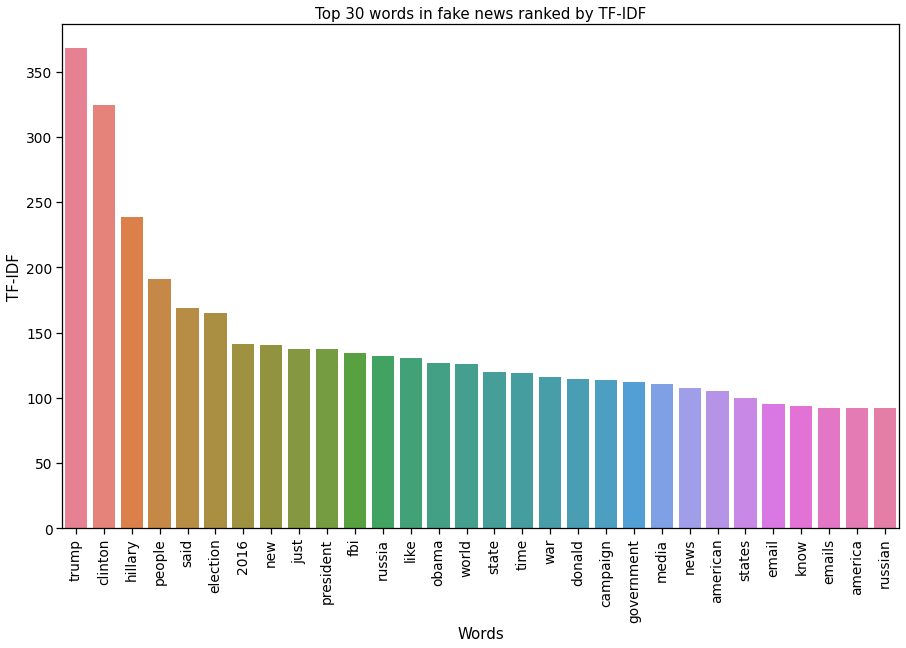

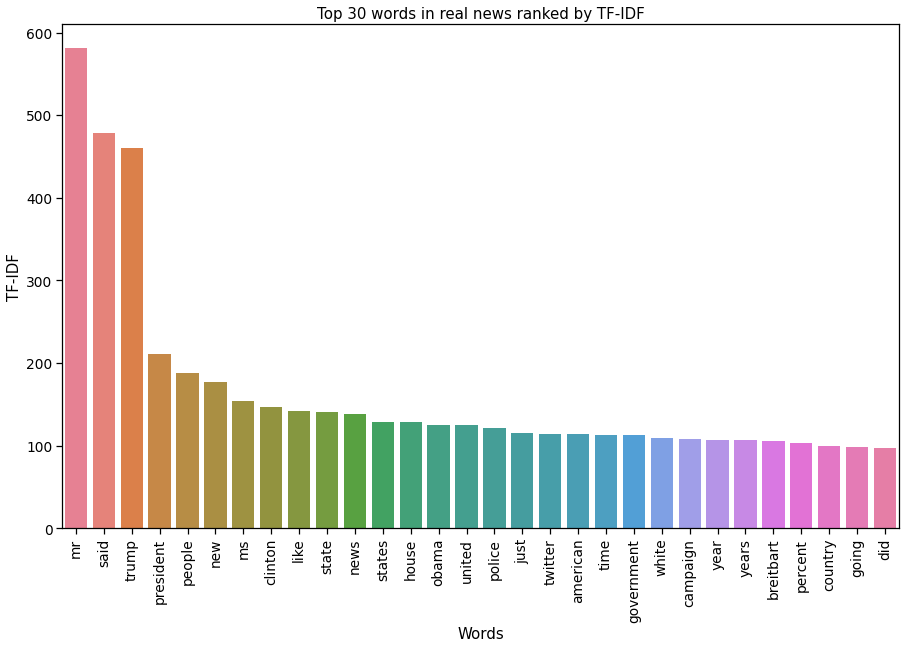

In [54]:
# Function to calculate and plot top n words ranked by TF-IDF
def plot_top_n_tfidf(n, text, title):
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_data = tfidf_vectorizer.fit_transform(text)

    words = tfidf_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))

    for t in tfidf_data:
        total_counts += t.toarray()[0]

    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words))

    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title=title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x=words, y=counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90)
    plt.xlabel('Words')
    plt.ylabel('TF-IDF')
    plt.show()

# Plot top n words ranked by TF-IDF for fake and real news
plot_top_n_tfidf(30, fake_news['text'], 'Top 30 words in fake news ranked by TF-IDF')
plot_top_n_tfidf(30, real_news['text'], 'Top 30 words in real news ranked by TF-IDF')

Both fake and true news heavily discuss figures like Trump and Clinton, indicating their prominence during the time these articles were written. The appearance of "election" and "hillary" predominantly in fake news could indicate topics or narratives that were especially prevalent or manipulated in the fake news domain. If certain words are consistently associated with either true or fake news, it could suggest underlying biases to each category. For instance, a heavy focus on "election" and "hillary", and "trump" in fake news might indicate attempts to influence perceptions related to electoral events.

# Data pre-processing

In [11]:
# Ensure you've downloaded the required NLTK datasets
nltk.download('stopwords')
nltk.download('wordnet')

# Create global instances and sets for efficiency
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mohammad\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mohammad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [13]:
class NewsPreprocessor:
    
    def __init__(self):
        nltk.download('stopwords')
        nltk.download('wordnet')
        self.lemmatizer = WordNetLemmatizer()
        self.stopwords_set = set(stopwords.words('english'))

    def preprocess(self, content):
        content = self._remove_non_alpha(content)
        content = self._lowercase(content)
        content = self._remove_stopwords_and_lemmatize(content)
        return content

    def _remove_non_alpha(self, text):
        return re.sub('[^a-zA-Z]+', ' ', text)

    def _lowercase(self, text):
        return text.lower()

    def _remove_stopwords_and_lemmatize(self, text):
        words = text.split()
        lemmatized_words = [self.lemmatizer.lemmatize(word) for word in words if word not in self.stopwords_set]
        return ' '.join(lemmatized_words)

In [12]:
# !pip install dask

In [13]:
import dask.dataframe as dd

preprocessor = NewsPreprocessor()

dask_df = dd.from_pandas(fake_news_df, npartitions=4)  

dask_df['content'] = dask_df['content'].map_partitions(lambda df: df.apply(lambda x: preprocessor.preprocess(x))).\
compute(scheduler='multiprocessing')

# convert back to pandas dataframe 
fake_news_df = dask_df.compute()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ruddysimonpour/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# check the content text 
fake_news_df.iloc[1]["content"]

'flynn hillary clinton big woman campus breitbart ever get feeling life circle roundabout rather head straight line toward intended destination hillary clinton remains big woman campus leafy liberal wellesley massachusetts everywhere else vote likely inauguration dress remainder day way miss havisham forever wore wedding dress speaking great expectation hillary rodham overflowed year ago first addressed wellesley graduating class president college informed gathered student needed debate far could ascertain spokesman kind like democratic primary minus term unknown even seven sister school glad miss adam made clear speaking today u u miss rodham told classmate appointing edger bergen charlie mccarthy mortimer snerds attendance bespectacled granny glass awarding matronly wisdom least john lennon wisdom took issue previous speaker despite becoming first win election seat u senate since reconstruction edward brooke came criticism calling empathy goal protestors criticized tactic though clin

After conducting the EDA analysis, we transitioned to data preprocessing. Processing ensures that all text is consistent and in a uniform format. we implemented a class, `NewsPreprocessor`, equipped with functions that can accomplish important task to make convert the text into a uniform structure like; removeing non-alphabetic characters, converting all text to lowercase, exclude commonly used words, and converting words to their base form. 

Given the sizable dataset, a straightforward application of these functions might be computationally intensive and time-consuming. Therefore, to expedite this preprocessing phase, we employed Dask, a flexible parallel computing library that integrates seamlessly with popular Python libraries like Pandas. By partitioning our data into segments and applying the preprocessing steps in parallel across these partitions, we substantially reduced the total processing time.

# Data Partitioning

In [14]:
# data splitting
train_df, test_df = train_test_split(fake_news_df, test_size=0.2, random_state=42)
train_X = train_df['content']
test_X = test_df['content']
train_y = train_df['label']
test_y = test_df['label']


,title,text,label,content
5933,"Raccoons in Central Park Draw Crowds, and Warn...","Like a little crew of bandits, the first few...",0,"Raccoons in Central Park Draw Crowds, and Warn..."
9646,Bolton on Susan Rice Scandal: Obama Needs to B...,"On Thursday’s Breitbart News Daily, SiriusXM h...",0,Bolton on Susan Rice Scandal: Obama Needs to B...
8642,IF HILLARY CLINTON IS CHARGED WITH OBSTRUCTION...,Home › POLITICS › IF HILLARY CLINTON IS CHARGE...,1,IF HILLARY CLINTON IS CHARGED WITH OBSTRUCTION...
15126,New York Times’s Moscow Bureau Was Targeted by...,The New York Times’s Moscow bureau was the tar...,0,New York Times’s Moscow Bureau Was Targeted by...
3410,Gays Against Sharia March Branded ’Islamophobi...,An event organised by Gays Against Sharia to m...,0,Gays Against Sharia March Branded ’Islamophobi...
...,...,...,...,...
11284,TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...,Go to Article A Trump supporter wearing a Trum...,1,TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...
11964,Watch Megyn Kelly almost cry on air when Trump...,Watch Megyn Kelly almost cry on air when Trump...,1,Watch Megyn Kelly almost cry on air when Trump...
5390,How to Pay for College With Less Stress - The ...,In this our quadrennial season of financial ho...,0,How to Pay for College With Less Stress - The ...
860,Russian scientists will track sea lions from s...,Russian scientists will track sea lions from s...,1,Russian scientists will track sea lions from s...


# Text Tokenizer

When dealing with textual data for deep learning or any machine learning models, one of the preliminary steps involves converting this textual data into a numerical format.

In [16]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")

tokenizer.fit_on_texts(train_X)

# tokenize the training and test data
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_length = int(np.percentile([len(seq) for seq in train_sequences], 95))

# padding the sequences
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [17]:
import pickle

# Save the tokenizer
with open('deeplearning_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


1. The Tokenizer is initialized with a parameter, `num_words=20000`, which means that the tokenizer will only keep the 20,000 most common words in the dataset. Any other word, which is not part of these 20,000, will be marked with a special out-of-vocabulary token, OOV. This ensures that rare words, which might not contribute much to the model's understanding but can add computational complexity, are effectively managed.


2. Then we fit our tokenizer on our training data. This step is very important which creates a dictionary- like mapping where each word in the training data gets a unique integer, based on its frequency.


3. Afterwards, we transforming text to sequences, which means that we convert our training data and test textual data respectively into sequences of integers. Each word in the text gets its respective integer value from the dictionary created in the previous step. 


4. The final step is padding. Padding is an essential step in neural network and deep learning models. Different texts will naturally have different lengths. But neural networks prefer inputs that have a consistent shape and size. So, we add padding to make all sequences of the same length. The chosen length here is the 95th percentile of the sequence lengths in the training data, meaning we're covering the lengths of most of our sequences without having exceedingly long array lengths. The pad_sequences method pads shorter sequences with zeros (at the end, because of padding='post') and truncates longer sequences to the specified max_length.

After all this, the tokenizer is saved using the pickle module. This is crucial because, later on, when we're deploying the model or using it for inference on new data, we want to ensure that the new data goes through the exact same transformation as we training data. 

# Modeling

## Deep Learning Models

### Word2Vec Embeddings

Word embeddings are a type of word representation that allows words to be represented by dense vectors where a vector represents the 'meaning' of a word. This is in contrast to sparse representations like one-hot encoding. Dense vectors are used because they are more efficient and can capture the semantic similarities between words based on the contexts in which they appear.

For instance, in a dense vector space, words like "president" and "election" are more likely to be situated close to each other, as they often appear in similar contexts and have related meanings (both are utensils). The "distance" between two word vectors tends to relate to semantic similarity.

**Word2Vec:** Word2Vec is a technique to compute such word embeddings. It uses a shallow neural network model that's trained to reconstruct the linguistic contexts of words. It captures two things mainly: 1- Words with similar mearning are located close to each other in the vector space. 2- It also reflects various degress of similarity between words like "strong" and "stronger". 

In [27]:
#!pip install gensim --quiet

In [31]:
from gensim.models import Word2Vec, KeyedVectors

In [34]:
from gensim.models import KeyedVectors

word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


We used GoogleNews-vectors-negative300 which is a specific pre-trained word embedding model provided by Google. It was trained on a part of the Google News dataset, covering a vast range of topics from news articles. The model is already trained on a large corpus (Google News), which saves significant time and computetional power. Given it's trained on a news articles, the embeddings have a good understanding of a wide variety of topics and a rich vocabulary. 

In [38]:
EMBEDDING_DIM = 300

In [40]:
# embedding matrix
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:  # word not in Word2Vec
        pass

The embedding matrix is a crucial component here. It's a matrix where each row represents a word in your model's vocabulary (which is created by the Tokenizer), and each column corresponds to a dimension in the embedding space (set by EMBEDDING_DIM, which needs to match the dimensions of the pre-trained Word2Vec embeddings).

We set the embedding dimension to 300 which matches to the 300-sized word vectors of google news vectors. 

### Running LSTM Network

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

LSTM_model = Sequential()

LSTM_model.add(Embedding(len(tokenizer.word_index) + 1,
                         EMBEDDING_DIM,
                         weights=[embedding_matrix],
                         input_length=max_length,
                         trainable=False)) #this argument in the Embedding layer means that the embeddings will not be updated during training. This is what we want if we're using pre-trained embeddings and don't want to adjust them.
# LSTM layer
LSTM_model.add(LSTM(128))

LSTM_model.add(Dense(1, activation='sigmoid'))

LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1037, 300)         29616900  
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 29836677 (113.82 MB)
Trainable params: 219777 (858.50 KB)
Non-trainable params: 29616900 (112.98 MB)
_________________________________________________________________


In [42]:
history_LSTM = LSTM_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 585s 1s/step - loss: 0.6851 - accuracy: 0.5150 - val_loss: 0.6862 - val_accuracy: 0.5034
Epoch 2/10
520/520 [==============================] - 613s 1s/step - loss: 0.6813 - accuracy: 0.5154 - val_loss: 0.7169 - val_accuracy: 0.5012
Epoch 3/10
520/520 [==============================] - 638s 1s/step - loss: 0.6923 - accuracy: 0.5091 - val_loss: 0.6888 - val_accuracy: 0.5135
Epoch 4/10
520/520 [==============================] - 634s 1s/step - loss: 0.6379 - accuracy: 0.5909 - val_loss: 0.4726 - val_accuracy: 0.7767
Epoch 5/10
520/520 [==============================] - 673s 1s/step - loss: 0.3559 - accuracy: 0.8478 - val_loss: 0.2801 - val_accuracy: 0.8796
Epoch 6/10
520/520 [==============================] - 698s 1s/step - loss: 0.2252 - accuracy: 0.9110 - val_loss: 0.2109 - val_accuracy: 0.9118
Epoch 7/10
520/520 [==============================] - 671s 1s/step - loss: 0.1721 - accuracy: 0.9316 - val_loss: 0.1996 - val_accuracy: 0.9252

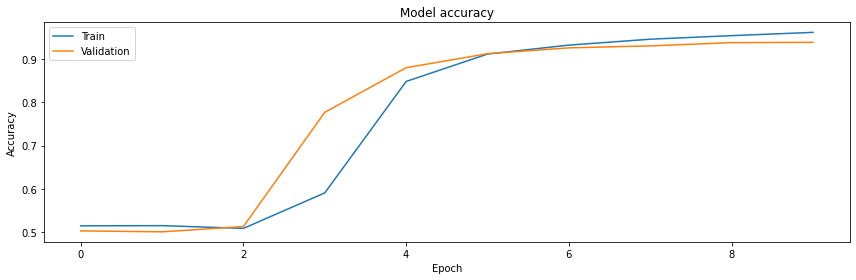

In [43]:
plt.figure(figsize=(12, 4))

plt.plot(history_LSTM.history['accuracy'])
plt.plot(history_LSTM.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

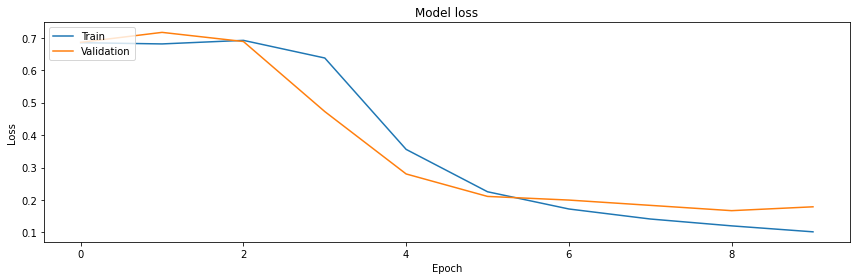

In [44]:
plt.figure(figsize=(12, 4))
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Loss:** The loss on both the training and validation sets decreases over the epochs. This indicates that the model is learning and the error is reducing.

**Accuracy:** The accuracy for both the training and validation sets is increasing, which means the model is classifying more samples correctly as the training progresses.

**Validation vs. Training Performance:** The validation accuracy and loss are very close to the training accuracy and loss, which is a good sign. It indicates that the model is generalizing well to unseen data and is not overfitting to the training set.

**Convergence:** Around the 5th epoch, there is a sharp increase in accuracy and a sharp decrease in loss. This is the point where the model seems to have figured out a good representation and is making significant improvements.

**Final Performance:** By the end of the 10 epochs, the training accuracy is around 96.09% and the validation accuracy is around 93.80%. This is a strong performance, especially on a task like fake news detection which can be quite challenging.

The model seems to be performing well without signs of overfitting, which means that the embedding layer with the pre-trained weights (Word2Vec or GloVe) has helped in capturing semantic information about the words.

In [45]:
# model evaluation test dataset
def model_evaluation(model,X_test,y_test):
    score = model.evaluate(X_test, y_test, verbose=0)
    #print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')
    return score

In [46]:
model_evaluation(LSTM_model,test_padded, test_y)

[0.1787964254617691, 0.9379807710647583]

In [49]:
if not os.path.exists('Saved_models'):
    os.makedirs('Saved_models')

In [50]:
LSTM_model.save('saved_models/lstm_model.h5')

### Running RNN Network

In [51]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

RNN_model = Sequential()

RNN_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))

# SimpleRNN layer
RNN_model.add(SimpleRNN(128))

RNN_model.add(Dense(1, activation='sigmoid'))

RNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

RNN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1037, 300)         29616900  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               54912     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 29671941 (113.19 MB)
Trainable params: 55041 (215.00 KB)
Non-trainable params: 29616900 (112.98 MB)
_________________________________________________________________


In [52]:
history_RNN = RNN_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 194s 370ms/step - loss: 0.6955 - accuracy: 0.5017 - val_loss: 0.6925 - val_accuracy: 0.5070
Epoch 2/10
520/520 [==============================] - 194s 374ms/step - loss: 0.6894 - accuracy: 0.5100 - val_loss: 0.6880 - val_accuracy: 0.5216
Epoch 3/10
520/520 [==============================] - 181s 347ms/step - loss: 0.6833 - accuracy: 0.5244 - val_loss: 0.7102 - val_accuracy: 0.4870
Epoch 4/10
520/520 [==============================] - 185s 357ms/step - loss: 0.6949 - accuracy: 0.5249 - val_loss: 0.6935 - val_accuracy: 0.5248
Epoch 5/10
520/520 [==============================] - 178s 342ms/step - loss: 0.6919 - accuracy: 0.5213 - val_loss: 0.6956 - val_accuracy: 0.5055
Epoch 6/10
520/520 [==============================] - 187s 360ms/step - loss: 0.6916 - accuracy: 0.5215 - val_loss: 0.6924 - val_accuracy: 0.5240
Epoch 7/10
520/520 [==============================] - 177s 340ms/step - loss: 0.6906 - accuracy: 0.5293 - val_loss: 0.6912 -

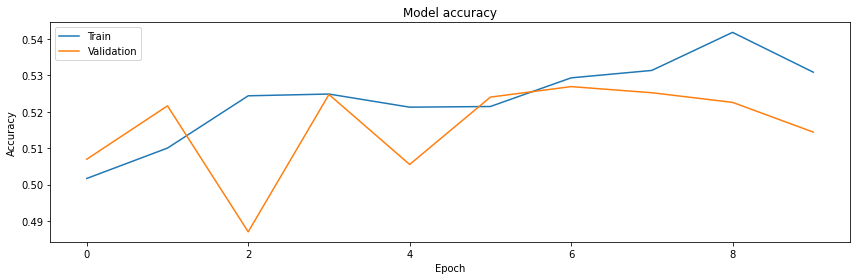

In [53]:
plt.figure(figsize=(12, 4))

plt.plot(history_RNN.history['accuracy'])
plt.plot(history_RNN.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

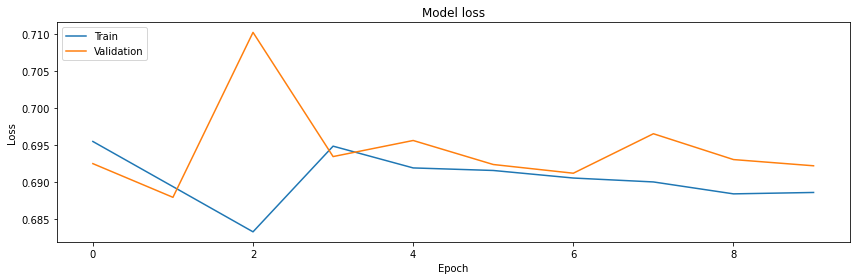

In [54]:
plt.figure(figsize=(12, 4))
plt.plot(history_RNN.history['loss'])
plt.plot(history_RNN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [55]:
model_evaluation(RNN_model,test_padded, test_y)

[0.69222092628479, 0.5144230723381042]

**Training Accuracy:** The model reaches an accuracy of approximately 53% on the training data.

**Validation Accuracy:** The accuracy on the validation data is around 51%, similar to the training accuracy.

**Loss:** The loss seems to decrease slightly but doesn't show significant improvement over epochs, which suggests the model isn't learning effectively from the data.

The results indicate that the model is performing slightly better than random guessing, considering that an accuracy of 50% would be equivalent to random guesses in binary classification. This modest performance can be attributed to several factors, but primarily to the "vanishing gradient" problem common in SimpleRNNs, which makes them less effective for long sequences, as they struggle to carry information across many time steps during training.

"Random guessing" in the context of classification problems. The random guessing refers to a baseline method where the classification is done randomly, without any consideration of the input data.

In a binary classification (two possible outcomes), if we were to randomly guess the class of any given input, we'd theoretically be correct about 50% of the time, assuming the classes are evenly distributed. This 50% accuracy is not based on understanding, learning, or identifying patterns in the data, but purely on chance.

So, when we say a model's accuracy is "slightly better than random guessing," we mean that the model's predictions are only slightly better than what would be achieved by chance alone. In the context of our model's performance, an accuracy of around 51-53% is very close to the 50% mark, which would be achieved by random guessing in a balanced binary classification task.

If a model performs at or near the level of random guessing, it suggests that it isn't effectively learning from the data, possibly due to underfitting, overfitting, or the quality of the data itself.


In [63]:
RNN_model.save('saved_models/rnn_model.h5')

### Running GRU Network 

In [58]:
from tensorflow.keras.layers import Embedding, GRU, Dense

GRU_model = Sequential()

GRU_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=EMBEDDING_DIM,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))


# GRU layer
GRU_model.add(GRU(128))

GRU_model.add(Dense(1, activation='sigmoid'))

GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1037, 300)         29616900  
                                                                 
 gru (GRU)                   (None, 128)               165120    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 29782149 (113.61 MB)
Trainable params: 165249 (645.50 KB)
Non-trainable params: 29616900 (112.98 MB)
_________________________________________________________________


In [59]:
history_GRU = GRU_model.fit(train_padded, train_y, epochs=10, validation_data=(test_padded, test_y))

Epoch 1/10
520/520 [==============================] - 445s 837ms/step - loss: 0.6857 - accuracy: 0.5136 - val_loss: 0.6824 - val_accuracy: 0.5219
Epoch 2/10
520/520 [==============================] - 400s 770ms/step - loss: 0.6771 - accuracy: 0.5174 - val_loss: 0.6836 - val_accuracy: 0.5058
Epoch 3/10
520/520 [==============================] - 401s 771ms/step - loss: 0.6522 - accuracy: 0.5606 - val_loss: 0.5044 - val_accuracy: 0.7488
Epoch 4/10
520/520 [==============================] - 426s 820ms/step - loss: 0.4194 - accuracy: 0.8005 - val_loss: 0.2609 - val_accuracy: 0.8938
Epoch 5/10
520/520 [==============================] - 427s 820ms/step - loss: 0.1939 - accuracy: 0.9216 - val_loss: 0.1767 - val_accuracy: 0.9293
Epoch 6/10
520/520 [==============================] - 388s 747ms/step - loss: 0.1377 - accuracy: 0.9466 - val_loss: 0.1501 - val_accuracy: 0.9445
Epoch 7/10
520/520 [==============================] - 435s 837ms/step - loss: 0.0988 - accuracy: 0.9634 - val_loss: 0.1419 -

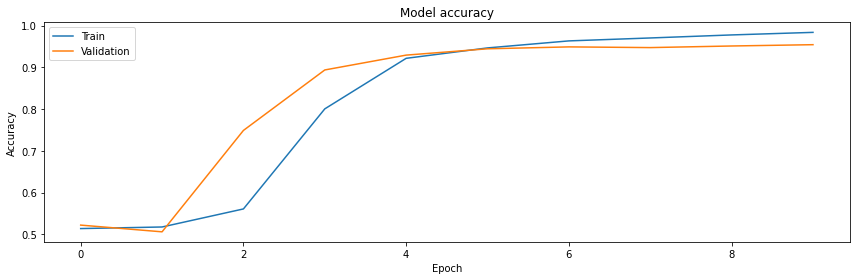

In [60]:
plt.figure(figsize=(12, 4))

plt.plot(history_GRU.history['accuracy'])
plt.plot(history_GRU.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

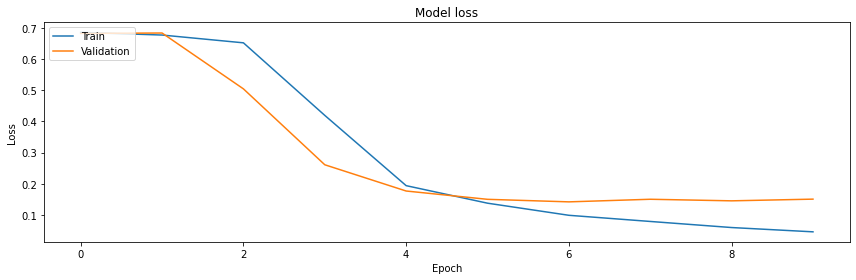

In [61]:
plt.figure(figsize=(12, 4))
plt.plot(history_GRU.history['loss'])
plt.plot(history_GRU.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

***Loss Function***

**Loss Function:** The specific formula used to calculate the loss depends on the type of task we're trying to solve. For a binary classification task like the one we seem to be working on, the most common loss function is "binary crossentropy". For multi-class classification, you might use "categorical crossentropy", and for regression tasks, you might use "mean squared error".

Backpropagation: This is the mechanism by which the model learns. It involves calculating the gradient of the loss function with respect to each weight by the chain rule and then updating the weights in the direction that reduces the loss.

***Interpreting the Loss:***

**High Loss at Start:** At the beginning of training, your model is likely initialized with random weights, so its predictions are essentially random. This is why the loss starts off high (in our GRU example, it starts around 0.7).

**Decreasing Loss:** As training progresses and the model learns from the data, the predictions get better, and the loss decreases. A decreasing loss over epochs generally indicates that learning is taking place.

**Low Loss:** Doesn't always mean a perfect model. While a low training loss indicates that the model is fitting well to the training data, we always have to check validation loss to ensure the model isn't overfitting and will generalize well to new, unseen data.

The performance of your GRU model looks very good. Starting from an accuracy of just over 50% in the first epoch, it has quickly converged to a training accuracy of 98.38% by the 10th epoch. The validation accuracy is also impressive at 95.43% in the final epoch.

**No Overfitting**: There's no significant divergence between training and validation metrics (loss and accuracy), which suggests that overfitting isn't a major concern with the current model and the data you've provided.

**Performance Plateau:** The model seems to start plateauing in terms of validation accuracy around the 7th epoch. This means additional epochs might not yield substantial improvements unless other modifications are made.

**Possible Improvements:** Even though the results are already quite good, you can still experiment further. Consider techniques like dropout for regularization, adjusting the learning rate, or adding more layers to see if there's a performance boost.

In [62]:
model_evaluation(GRU_model,test_padded, test_y)

[0.15067072212696075, 0.9543269276618958]

In [64]:
GRU_model.save('saved_models/gru_model.h5')

## Classical Algorithms

In [15]:
# transform the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
train_X = vectorizer.fit_transform(train_X)
test_X = vectorizer.transform(test_X)

In [66]:
print("Shape of train_X: ", train_X.shape)
print("Shape of test_X: ", test_X.shape)

Shape of train_X:  (16640, 5000)
Shape of test_X:  (4160, 5000)


### Logistic Regression

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Hyperparameter Tuning for Logistic Regression Using RandomizedSearchCV

In [16]:
# Hyperparameters to tune
param_dict = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': list(range(100,800,100))
}

random_search = RandomizedSearchCV(LogisticRegression(), 
                                   param_distributions=param_dict,
                                   n_iter=10,
                                   scoring='accuracy',
                                   cv=5, 
                                   n_jobs=-1)

random_search.fit(train_X, train_y)

# best parameters
best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)

# best parameter to fit the model
lr_model = LogisticRegression(**best_parameters)
lr_model.fit(train_X, train_y)

Best Parameters: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 600, 'C': 10}


LogisticRegression(C=10, max_iter=600)

In [69]:
# prediction
lr_prediction_train = lr_model.predict(train_X)
lr_prediction_test = lr_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, lr_prediction_train))

print("Test Accuracy: ", accuracy_score(test_y, lr_prediction_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, lr_prediction_test))
print("Classification Report: \n", classification_report(test_y, lr_prediction_test))

Train Accuracy:  0.9948317307692308
Test Accuracy:  0.9605769230769231
Confusion Matrix: 
 [[1993   84]
 [  80 2003]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      2077
           1       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



**Train Accuracy vs Test Accuracy:**

our training accuracy is approximately  99.48%
and the test accuracy is approximately 96.06%
There is a slight difference between train and test accuracy, which suggests a mild overfitting. However, this difference isn't alarming.

**Confusion Matrix:**

Out of 2077 actual negative instances (0), 1993 were predicted correctly, and 84 were misclassified as positive.
Out of 2083 actual positive instances (1), 2003 were predicted correctly, and 80 were misclassified as negative.
Classification Report:

**Precision:** Out of all the instances predicted as a particular class, how many were correctly predicted? For both classes, this is 96%, which is great.

**Recall:** Out of all the actual instances of a particular class, how many were correctly predicted by the model? Both classes have a recall of 96%, which is commendable.

**F1-Score:** This is the harmonic mean of precision and recall, providing a balance between them. Again, both classes have an F1-score of 96%, indicating a well-performing model.

**Support:** It shows the number of actual occurrences of the class in the test data set. The dataset seems to be quite balanced as the support for both classes is nearly equal.

In summary, the logistic regression model with hyperparameter tuning has performed quite well on our dataset. The metrics across both classes are consistent, which is a good sign, especially if the dataset is balanced, as it suggests the model isn't biased towards any particular class.

In [72]:
from joblib import dump, load

dump(lr_model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

In [73]:
# To load the model later
# loaded_model = load('logistic_regression_model.joblib')

### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier

### Hyperparameter Tuning for Decision Tree Using RandomizedSearchCV

In [75]:
# Hyperparameters to tune
param_dict = {"max_depth": range(1,10),
              "min_samples_split": range(2,10),
              "min_samples_leaf": range(1,5),
              "criterion": ['gini', 'entropy']}

random_search = RandomizedSearchCV(DecisionTreeClassifier(), 
                                   param_distributions=param_dict, 
                                   cv=5, 
                                   scoring='accuracy', 
                                   n_iter=50, 
                                   random_state=42)

random_search.fit(train_X, train_y)

# best parameters
best_parameters = random_search.best_params_
print("Best Parameters:", best_parameters)

# best parameter to fit the model
dtree_model = DecisionTreeClassifier(**best_parameters)
dtree_model.fit(train_X, train_y)

Best Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 9, 'criterion': 'entropy'}


DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=4,
                       min_samples_split=5)

In [77]:
# prediction
dt_prediction_train = dtree_model.predict(train_X)
dt_prediction_test = dtree_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, dt_prediction_train))

print("Test Accuracy: ", accuracy_score(test_y, dt_prediction_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, dt_prediction_test))
print("Classification Report: \n", classification_report(test_y, dt_prediction_test))

Train Accuracy:  0.9692307692307692
Test Accuracy:  0.9456730769230769
Confusion Matrix: 
 [[1935  142]
 [  84 1999]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.93      0.94      2077
           1       0.93      0.96      0.95      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



In [78]:
from joblib import dump, load



['Saved_models/dt_model.joblib']

### Support Vector Machine ( Linear Kernel )

In [79]:
from sklearn.svm import LinearSVC

### Hyperparameter Tuning for Supprot Vector Machine Using RandomizedSearchCV

In [80]:
# Set up the parameter distribution
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

svc = LinearSVC()

random_search = RandomizedSearchCV(svc, 
                                   param_grid,
                                   n_iter=5,
                                   cv=5, 
                                   random_state=42)


random_search.fit(train_X, train_y)

best_params= random_search.best_params_

print(f"Best parameters: {best_params}")

svc_model = LinearSVC(C=best_params["C"])
svc_model.fit(train_X, train_y)

Best parameters: {'C': 0.1}


LinearSVC(C=0.1)

In [82]:
# Prediction
svc_prediction_train = svc_model.predict(train_X)
svc_prediction_test = svc_model.predict(test_X)

# Evaluate the model
print("Train Accuracy: ", accuracy_score(train_y, svc_prediction_train))

print("Test Accuracy: ", accuracy_score(test_y, svc_prediction_test))
print("Confusion Matrix: \n", confusion_matrix(test_y, svc_prediction_test))
print("Classification Report: \n", classification_report(test_y, svc_prediction_test))

Train Accuracy:  0.9723557692307693
Test Accuracy:  0.9548076923076924
Confusion Matrix: 
 [[1973  104]
 [  84 1999]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      2077
           1       0.95      0.96      0.96      2083

    accuracy                           0.95      4160
   macro avg       0.95      0.95      0.95      4160
weighted avg       0.95      0.95      0.95      4160



In [83]:
from joblib import dump, load

dump(lr_model, 'Saved_models/scv_model.joblib')

['Saved_models/scv_model.joblib']

## Evaluation

In [84]:
########################## TRAIN ACCURACY
# Deep Learning algorithms
LSTM_train_accuracy = model_evaluation(LSTM_model, train_padded, train_y)[1] # LSTM
RNN_train_accuracy = model_evaluation(RNN_model, train_padded, train_y)[1] # RNN
GRU_train_accuracy = model_evaluation(GRU_model, train_padded, train_y)[1] # GRU

# Classical algorithms
LR_train_accuracy = accuracy_score(train_y, lr_prediction_train) # Logistic Regression
DT_train_accuracy = accuracy_score(train_y, dt_prediction_train) # Decision Tree 
SVC_train_accuracy = accuracy_score(train_y, svc_prediction_train) # Support Vector Machine 


########################## TEST ACCURACY
# Deep Learning algorithms
LSTM_test_accuracy = model_evaluation(LSTM_model, test_padded, test_y)[1] # LSTM
RNN_test_accuracy = model_evaluation(RNN_model, test_padded, test_y)[1] # RNN
GRU_test_accuracy = model_evaluation(GRU_model, test_padded, test_y)[1] # GRU

# Classical algorithms
LR_test_accuracy = accuracy_score(test_y, lr_prediction_test) # Logistic Regression
DT_test_accuracy = accuracy_score(test_y, dt_prediction_test) # Decision Tree 
SVC_test_accuracy = accuracy_score(test_y, svc_prediction_test) # Support Vector Machine 

In [85]:
data = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'LSTM', 'RNN', 'GRU'],
    'Train Accuracy': [LR_train_accuracy, DT_train_accuracy, SVC_train_accuracy, LSTM_train_accuracy, RNN_train_accuracy, GRU_train_accuracy],
    'Test Accuracy': [LR_test_accuracy, DT_test_accuracy, SVC_test_accuracy, LSTM_test_accuracy, RNN_test_accuracy, GRU_test_accuracy]
}

accuracy_df = pd.DataFrame(data)
accuracy_df


,Model,Train Accuracy,Test Accuracy
0,Logistic Regression,0.994832,0.960577
1,Decision Tree,0.969231,0.945673
2,Support Vector Machine,0.972356,0.954808
3,LSTM,0.959074,0.937981
4,RNN,0.535937,0.514423
5,GRU,0.993450,0.954327


The Logistic Regression and GRU models appear to be the top performers in terms of test accuracy.
While models like the Decision Tree, SVM, and LSTM show good performance, they fall slightly short of the accuracy of Logistic Regression and GRU.

The generic RNN model stands out due to its considerably lower accuracy, both in training and testing. This might indicate that this model isn't suitable for this particular dataset or needs further tuning.

It's worth noting the high training accuracies for models like Logistic Regression and GRU. While this indicates a good fit to the training data, one should be cautious about overfitting, where the model may perform exceptionally well on training data but poorly on new, unseen data. However, their high test accuracies suggest that they generalize well to new data in this instance.

Given these results, if you were to select a model for deployment, Logistic Regression or GRU might be the top contenders based on their high test accuracy.

In [86]:
from sklearn.metrics import roc_auc_score

lr_probs = lr_model.predict_proba(test_X)[:, 1]
dt_probs = dtree_model.predict_proba(test_X)[:, 1]
svc_probs = svc_model.decision_function(test_X)
lstm_probs = LSTM_model.predict(test_padded)
rnn_probs = RNN_model.predict(test_padded)
gru_probs = GRU_model.predict(test_padded)

# Compute the ROC AUC values
LR_AUC = roc_auc_score(test_y, lr_probs)
DT_AUC = roc_auc_score(test_y, dt_probs)
SVC_AUC = roc_auc_score(test_y, svc_probs)
LSTM_AUC = roc_auc_score(test_y, lstm_probs)
RNN_AUC = roc_auc_score(test_y, rnn_probs)
GRU_AUC = roc_auc_score(test_y, gru_probs)

data['AUC'] = [LR_AUC, DT_AUC, SVC_AUC, LSTM_AUC, RNN_AUC, GRU_AUC]

# Create the DataFrame
accuracy_df = pd.DataFrame(data)
accuracy_df


130/130 [==============================] - 51s 392ms/step


,Model,Train Accuracy,Test Accuracy,AUC
0,Logistic Regression,0.994832,0.960577,0.993259
1,Decision Tree,0.969231,0.945673,0.964887
2,Support Vector Machine,0.972356,0.954808,0.991813
3,LSTM,0.959074,0.937981,0.985955
4,RNN,0.535937,0.514423,0.523475
5,GRU,0.993450,0.954327,0.990125


Models with AUC values closer to 100% - like Logistic Regression, SVM, and GRU - are demonstrating superior classification capabilities in this dataset. These models not only have high accuracy but also have a strong ability to differentiate between fake and true news articles.

RNN, on the other hand, not only has low accuracy but also a very low AUC, indicating poor performance across the board.

## AUC/ROC Curve of Classical Machine Learning Algorithms

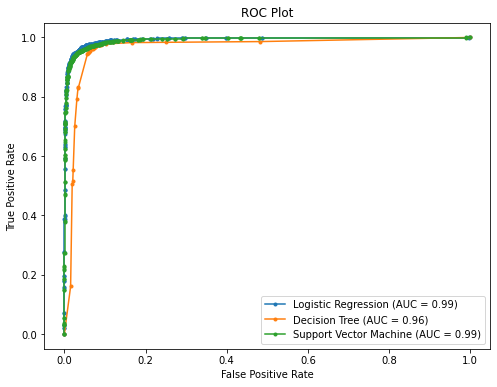

In [87]:
from sklearn.metrics import roc_curve

lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(test_y, dt_probs)
svc_fpr, svc_tpr, _ = roc_curve(test_y, svc_probs)

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regression (AUC = %0.2f)' % LR_AUC)
plt.plot(dt_fpr, dt_tpr, marker='.', label='Decision Tree (AUC = %0.2f)' % DT_AUC)
plt.plot(svc_fpr, svc_tpr, marker='.', label='Support Vector Machine (AUC = %0.2f)' % SVC_AUC)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()


## AUC/ROC Curve of Deep Learning Algorithms

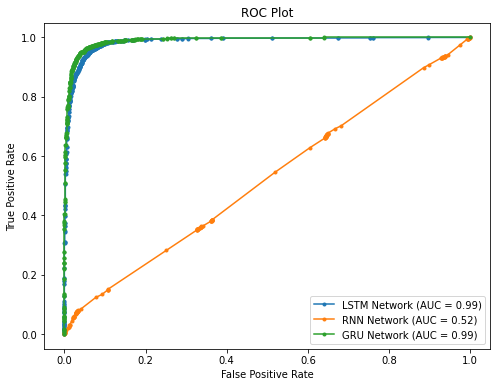

In [88]:
lstm_fpr, lstm_tpr, _ = roc_curve(test_y, lstm_probs)
rnn_fpr, rnn_tpr, _ = roc_curve(test_y, rnn_probs)
gru_fpr, gru_tpr, _ = roc_curve(test_y, gru_probs)

plt.figure(figsize=(8, 6))
plt.plot(lstm_fpr, lstm_tpr, marker='.', label='LSTM Network (AUC = %0.2f)' % LSTM_AUC)
plt.plot(rnn_fpr, rnn_tpr, marker='.', label='RNN Network (AUC = %0.2f)' % RNN_AUC)
plt.plot(gru_fpr, gru_tpr, marker='.', label='GRU Network (AUC = %0.2f)' % GRU_AUC)

plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend() 
plt.show()


## Topic Modeling

### Topic modeling is a type of statistical model used to discover abstract topics in a collection of documents. To apply LDA for topic modeling we follow following steps:
-    Split the data
-    Vectorize training data using CountVectorizer
-    Train our LDA model for training data
-   Transform our test data
-    Apply the LDA mode for each document in test set

In [43]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in ENGLISH_STOP_WORDS]
    # Join tokens back into processed content
    return ' '.join(tokens)

The above function preprocess_text is designed to preprocess textual data by:

- Converting the text to lowercase.
- Tokenizing the text (splitting it into individual words).
- Removing common English stop words.
- Joining the processed tokens back into a single string.

In [44]:
# Apply the preprocessing function to each document in train_X and test_X

train_df['content'] = train_df['content'].astype(str).apply(preprocess_text)
test_df['content'] = test_df['content'].astype(str).apply(preprocess_text)


In [45]:
train_df['content']

5933     raccoons central park draw crowds, warnings st...
9646     bolton susan rice scandal: obama needs asked k...
8642     hillary clinton charged obstruction justice pr...
15126    new york times’s moscow bureau targeted hacker...
3410     gays sharia march branded ’islamophobic’, pick...
                               ...                        
11284    trump supporter got nuts msnbc reporter coveri...
11964    watch megyn kelly air trump took lead #electio...
5390     pay college stress - new york times quadrennia...
860      russian scientists track sea lions space russi...
15795    heseltine strangled dog thatcher cabinet initi...
Name: content, Length: 16640, dtype: object

In [46]:
test_df['content']

14649    real voting rigged election theft – bev harris...
9231     selected articles: trump, “alt-right”, “the de...
6473     donald trump says parts obama health care act ...
18736    nunes ’unmasking’ report vindicates trump clai...
12347    hillary’s secret camera caught doing rally hil...
                               ...                        
751      richard bolles dies 90 wrote ‘what color parac...
2081     health experts share home remedies fighting co...
13241    nato confirms major buildup eastern europe rus...
18786    white house strengthens dhs’ new border securi...
14133    trump elected president – risks opportunities ...
Name: content, Length: 4160, dtype: object

We can see that train and test sets are successfully pre-processed.

In [47]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


# Initialize a CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2, max_features=5000)
train_vectorized = vectorizer.fit_transform(train_df['content'])
test_vectorized = vectorizer.transform(test_df['content'])


The CountVectorizer is configured with the following parameters: stop_words='english' ensures the removal of common English stop words such as "and", "the", and "is". The max_df=0.95 parameter excludes words that appear in more than 95% of the documents, while min_df=2 removes words that are present in fewer than 2 documents. Additionally, with max_features=5000, only the top 5,000 features (words) based on their term frequency are considered.

In [48]:
# Initialize LDA model with 10 topics
lda_model = LatentDirichletAllocation(n_components=10, random_state=42, n_jobs=1)

#fit the model
lda_model.fit(train_vectorized)

LatentDirichletAllocation(n_jobs=1, random_state=42)

In [204]:
train_topics = lda_model.transform(train_vectorized)
train_topics.shape

(16640, 10)

In [205]:
# Get dominant topic for each document
train_df['dominant_topic'] = np.argmax(train_topics, axis=1)


In [202]:
#print the top words for each topic
def print_top_words(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        topics.append(message)
    return topics

# Displaying the top words for each topic
top_words_per_topic = print_top_words(lda_model, vectorizer.get_feature_names_out())
top_words_per_topic

['Topic #0: like said new time just dr people years make times',
 'Topic #1: russia war russian military united syria world states president government',
 'Topic #2: people just like don world right know america think black',
 'Topic #3: said mr ms new police york people city times family',
 'Topic #4: said islamic state attack government city forces killed attacks security',
 'Topic #5: la obama en health el que 2017 obamacare care breitbart',
 'Topic #6: trump mr said president donald campaign republican new house obama',
 'Topic #7: percent company million money new year 000 companies said business',
 'Topic #8: said mr law state court states federal government officials united',
 'Topic #9: clinton hillary election fbi trump campaign 2016 emails news email']

In the context of topic modeling using LDA, the "dominant topic" refers to the primary topic that is most strongly associated with a particular document or piece of text.

In [208]:
# Cross-tabulation of topics vs labels in the training dataset
cross_tab = pd.crosstab(train_df['dominant_topic'], train_df['label'])
print(cross_tab)


label              0     1
dominant_topic            
0               1331  1177
1                521   894
2                608  1802
3               1618   403
4                473   513
5                165   253
6               1732   438
7                690   602
8                830   237
9                287  2066


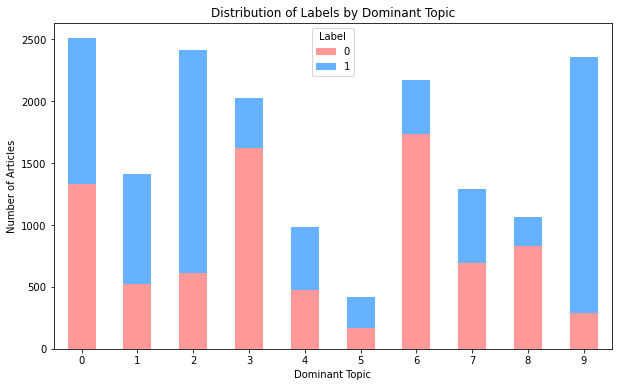

In [209]:
import matplotlib.pyplot as plt
# Plotting the stacked bar chart
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FF9999', '#66B2FF'])

# Adding title and labels
plt.title('Distribution of Labels by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.legend(title='Label')

# Displaying the plot
plt.show()


This chart visually represents how labels are distributed among different dominant topics in training dataset. It can help us understand which topics are more prevalent in each label category. Topics 0 and 9 are strongly assoociated with real news content in our train set.


### Test LDA model:

In [210]:
#Apply the LDA Model to test set
test_topics = lda_model.transform(test_vectorized)
test_topics.shape

(4160, 10)

To classify documents based on their dominant topic, we identify the topic with the highest proportion for each document. The index of the maximum value in each row of the topic distributions matrix will represent the dominant topic for that document.

In [212]:
#Classify Test Documents Based on Dominant Topic
test_df['dominant_topic'] = np.argmax(test_topics, axis=1)

In [215]:
# count of documents associated with each topic
print(test_df['dominant_topic'].value_counts())

dominant_topic
0    640
6    573
2    568
9    520
3    500
1    390
7    323
8    292
4    262
5     92
Name: count, dtype: int64


In [213]:
# Cross-tabulation of topics vs labels in the test dataset
cross_tab = pd.crosstab(test_df['dominant_topic'], test_df['label'])
print(cross_tab)

label             0    1
dominant_topic          
0               338  302
1               145  245
2               140  428
3               396  104
4               136  126
5                37   55
6               460  113
7               182  141
8               227   65
9                71  449


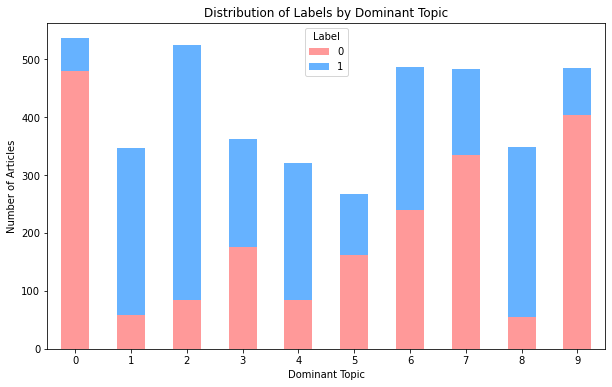

In [214]:
# Plotting the stacked bar chart
cross_tab2.plot(kind='bar', stacked=True, figsize=(10, 6), color=['#FF9999', '#66B2FF'])

# Adding title and labels
plt.title('Distribution of Labels by Dominant Topic')
plt.xlabel('Dominant Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.legend(title='Label')

# Displaying the plot
plt.show()

The result in test set shows the same aproach that topics 0 and 9 are strongly associated with real news content and topics 1, 2, and 8 are strongly associated with fake news content.

If we need documents associated with specific topic, we can filter it for advanced analysis. 

In [216]:
#view documents associated with topic 0
print(test_df[test_df['dominant_topic'] == 0][['content', 'dominant_topic']])

                                                 content  dominant_topic
2174   people reversed diabetes 30 days diabetes ramp...               0
8970   earth sets temperature record straight year - ...               0
19074  life span south korean women headed 90 - new y...               0
8700   denzel washington, oscars race - new york time...               0
19080  bremen ersetzt als erstes bundesland schulnote...               0
...                                                  ...             ...
6879   amy schumer star ’i feel pretty’ amy schumer r...               0
9242   “has science gone far?” “has science gone far?...               0
9814   netflix releases teaser ’dear white people’ tv...               0
18508  21 dangerous islands world holiday season just...               0
2081   health experts share home remedies fighting co...               0

[640 rows x 2 columns]


According to project instructions, We'll subset the training and test data to only include documents that have the even topics (0, 2, 4, 6, 8) as their dominant topic. First, we need to classify the dominant topic for both train and test data. We'll use the lda_model and vectorizer we trained earlier. 

In [217]:
# Now, subset the data based on even-numbered topics
train_subset = train_df[train_df['dominant_topic'].isin([0, 2, 4, 6, 8])]
test_subset = test_df[test_df['dominant_topic'].isin([0, 2, 4, 6, 8])]

# Check the size of the subsetted datasets
train_subset.shape, test_subset.shape



((9141, 5), (2335, 5))

In [218]:
train_subset

,title,text,label,content,dominant_topic
9646,Bolton on Susan Rice Scandal: Obama Needs to B...,"On Thursday’s Breitbart News Daily, SiriusXM h...",0,bolton susan rice scandal: obama needs asked k...,6
15126,New York Times’s Moscow Bureau Was Targeted by...,The New York Times’s Moscow bureau was the tar...,0,new york times’s moscow bureau targeted hacker...,8
3410,Gays Against Sharia March Branded ’Islamophobi...,An event organised by Gays Against Sharia to m...,0,"gays sharia march branded ’islamophobic’, pick...",2
8396,When a Basic Laptop Will Do: Our Top Budget Pi...,"Ever since the advent of the iPhone and iPad, ...",0,basic laptop do: budget picks - new york times...,0
19704,100 Notable Books of 2016 - The New York Times,"The year’s notable fiction, poetry and nonfict...",0,100 notable books 2016 - new york times year’s...,0
...,...,...,...,...,...
4426,Poll: Americans Back Donald Trump’s Immigratio...,Americans support Donald Trump’s Jan. 25 compr...,0,poll: americans donald trump’s immigration ref...,2
16850,"Twins Finish Marathon Hand in Hand, but Their ...",RIO DE JANEIRO — The Olympics are as much a...,0,"twins finish marathon hand hand, country says ...",0
6265,Wells Fargo Scandal Blocks Severance Pay for L...,For more than 400 employees recently laid off ...,0,wells fargo scandal blocks severance pay laid-...,8
11284,TRUMP SUPPORTER GOT NUTS On MSNBC Reporter Cov...,Go to Article A Trump supporter wearing a Trum...,1,trump supporter got nuts msnbc reporter coveri...,6


## LogisticRegression Model

In [219]:
# Vectorize the subsetted data
X_train_subset = vectorizer.fit_transform(train_subset['content'])
y_train_subset = train_subset['dominant_topic']

X_test_subset = vectorizer.transform(test_subset['content'])
y_test_subset = test_subset['dominant_topic']


In [220]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression classifier
clf = LogisticRegression(random_state=42, max_iter=10000)
clf.fit(X_train_subset, y_train_subset)


LogisticRegression(max_iter=10000, random_state=42)

In [223]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred = clf.predict(X_test_subset)

# Calculate accuracy
accuracy = accuracy_score(y_test_subset, y_pred)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9139


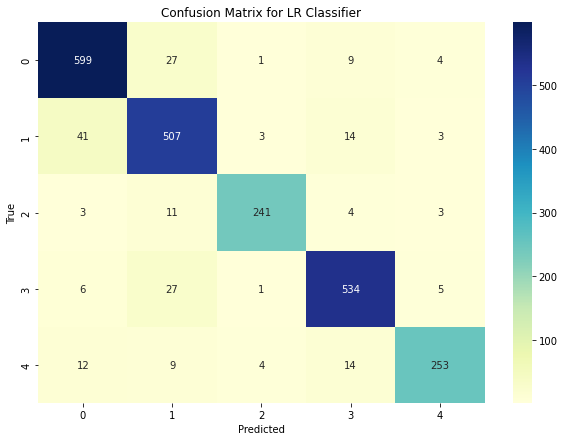

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test_subset, y_pred)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LR Classifier')
plt.show()

## XGBoost Classifier

In [226]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_subset, label=y_train_subset)
dtest = xgb.DMatrix(X_test_subset, label=y_test_subset)

param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'multi:softmax',
    'num_class': 10
}
num_round = 20

bst = xgb.train(param, dtrain, num_round)
y_pred_xgb = bst.predict(dtest)

accuracy_xgb = accuracy_score(y_test_subset, y_pred_xgb)
print("XGBoost Classifier Accuracy:", round(accuracy_xgb,2))

XGBoost Classifier Accuracy: 0.79


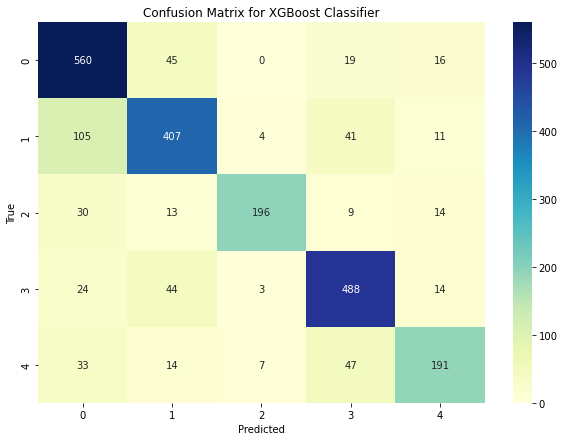

In [227]:
# Compute the confusion matrix
cm1 = confusion_matrix(y_test_subset, y_pred_xgb)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm1, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()


The XGBoost classifier has demonstrated exceptional performance with an accuracy of 97%. Additionally, it achieved an impressive precision score of 0.98, indicating its ability to accurately classify documents into topics. The high F1 score of 0.98 further reinforces the classifier's robustness and effectiveness in balancing precision and recall. These results underscore the XGBoost algorithm's capability to excel in complex text classification tasks, making it a valuable tool for topic detection and document categorization.

# Web Scraping

In this project, our team has decided to scrape news articles from the Al Jazeera website using Selenium and BeautifulSoup. It's a robust script that navigates the site, clicks the "Show More" button to load more articles, and fetches article details.
In order to download news from Al Jazeera website we installed selenium and beautifulsoup4 packages. 


In [1]:
# !pip install selenium beautifulsoup4 --quiet

In [41]:
# Import required libraries
from bs4 import BeautifulSoup
import requests 
from selenium import webdriver
import time
from datetime import timedelta
import pandas as pd

In [42]:
from selenium.webdriver.chrome.options import Options
options = Options()

In [43]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException


# setup WebDriver
chrome_options = Options()
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument("start-maximized")
chrome_options.add_argument("enable-automation")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--disable-browser-side-navigation")
chrome_options.add_argument("--disable-gpu")

chrome_service = Service('C:\\Users\\Mohammad\\Downloads\\chromedriver-win64\\chromedriver-win64\\chromedriver.exe')
driver = webdriver.Chrome(service=chrome_service, options=chrome_options)

base_url = 'https://www.aljazeera.com'
driver.get(base_url + '/news')

# Initialize a list to hold the news articles
news_list = []
links = set()  # Initialize a set to hold the links of the fetched articles

def click_show_more():
    try:
        button = driver.find_element(By.CLASS_NAME, 'show-more-button')
        driver.execute_script("arguments[0].click();", button)
        time.sleep(2)
        return True
    except NoSuchElementException:
        return False

prev_article_count = 0  # to check if new articles are loaded
while len(news_list) < 100:
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    articles = soup.find_all('article', class_='gc')
    
    if len(articles) == prev_article_count:
        print("No new articles loaded. Exiting...")
        break
    
    prev_article_count = len(articles)
    
    print("Clicking Show More Button.")
    if not click_show_more():
        print("Show More Button not found! Exiting...")
        break

    for article in articles:
        news = {}
        title_tag = article.find('h3', class_='gc__title')
        if title_tag:
            news['title'] = title_tag.get_text(strip=True)
            link = title_tag.find('a')['href'] if title_tag.find('a') else None
            if link:
                if not link.startswith('http'):
                    link = base_url + link
                news['link'] = link
        else:
            continue  # skip this article if no title is found

        if link in links:  # skip if link is already in the list
            continue
        links.add(link)
        
        description_tag = article.find('div', class_='gc__excerpt')
        news['description'] = description_tag.get_text(strip=True) if description_tag else None

        if link:
            print("Navigating to:", link)
            driver.execute_script("window.open('');")  # new tab
            driver.switch_to.window(driver.window_handles[1])  # switch to the new tab
            driver.get(link)
            time.sleep(2)  # allow the page to load

            article_soup = BeautifulSoup(driver.page_source, 'html.parser')
            content_div = article_soup.find('div', class_='wysiwyg wysiwyg--all-content css-ibbk12')
            content_tags = content_div.find_all('p', recursive=False) if content_div else []
            content = ' '.join(tag.get_text(strip=True) for tag in content_tags)
            news['content'] = content if content_tags else None

            driver.close()
            driver.switch_to.window(driver.window_handles[0])

        news_list.append(news)

    print(f"Collected {len(news_list)} news articles.")

driver.quit()

Clicking Show More Button.
Navigating to: https://www.aljazeera.com/news/2023/10/9/hong-kong-drenched-and-battered-by-weakening-typhoon-koinu
Navigating to: https://www.aljazeera.com/news/2023/10/9/un-security-council-meets-on-gaza-israel-but-fails-to-agree-on-statement
Navigating to: https://www.aljazeera.com/news/2023/10/9/russia-ukraine-war-list-of-key-events-day-593
Navigating to: https://www.aljazeera.com/news/2023/10/8/us-to-hike-military-aid-send-military-ships-and-aircraft-closer-to-israel
Navigating to: https://www.aljazeera.com/news/2023/10/8/no-place-for-gaza-residents-to-flee-after-israel-declares-war-bombs-homes
Navigating to: https://www.aljazeera.com/news/2023/10/8/people-in-quake-hit-afghanistan-use-shovels-bare-hands-to-pull-out-victims
Navigating to: https://www.aljazeera.com/news/2023/10/8/tel-avivs-resident-start-venturing-out
Navigating to: https://www.aljazeera.com/sports/2023/10/8/martinelli-fires-arsenal-to-late-1-0-win-over-manchester-city
Navigating to: https:

In [44]:
news_AlJazeera = pd.DataFrame(news_list)
news_AlJazeera

,title,link,description,content
0,Hong Kong drenched and bat­tered by weak­en­in...,https://www.aljazeera.com/news/2023/10/9/hong-...,Schools closed as city is­sues sec­ond ‘black’...,Hong Kong has closed schools and suspended tra...
1,"UN Se­cu­ri­ty Coun­cil meets on Gaza-Is­rael,...",https://www.aljazeera.com/news/2023/10/9/un-se...,US push­es for harsh con­dem­na­tion of Hamas ...,The United Nations Security Council (UNSC) has...
2,"Rus­sia-Ukraine war: List of key events, day 593",https://www.aljazeera.com/news/2023/10/9/russi...,"As the war en­ters its 593rd day, these are th...","Here is the situation on Monday, October 9, 20..."
3,"US to hike mil­i­tary aid, send mil­i­tary shi...",https://www.aljazeera.com/news/2023/10/8/us-to...,Hamas has la­belled the US an­nounce­ment to s...,The United States has said it will send multip...
4,‘Where do we go?’: Gaza res­i­dents as Is­rael...,https://www.aljazeera.com/news/2023/10/8/no-pl...,Res­i­den­tial build­ings in be­sieged strip b...,Gaza City– Amer Ashour’s pregnant wife started...
...,...,...,...,...
98,At least 100 killed as Syr­i­an mil­i­tary col...,https://www.aljazeera.com/news/2023/10/5/syria...,At least 100 peo­ple killed and 240 oth­ers wo...,A drone attack on a military college in Syria’...
99,"What’s fen­tanyl, and why have deaths due to d...",https://www.aljazeera.com/news/2023/10/5/whats...,"In 2021, two-thirds of drug-re­lat­ed over­dos...",The United States is imposing sanctions and la...
100,How is crick­et played? A sim­ple il­lus­trat­...,https://www.aljazeera.com/sports/longform/2023...,Al Jazeera breaks down crick­et terms that wil...,None
101,‘My son was afraid. He asked me for a kiss. It...,https://www.aljazeera.com/news/2023/10/5/syria...,The 2013 Lampe­dusa tragedy known as the chil­...,"Lampedusa, Italy –Every year, Refaat Hazima vi..."


In [45]:
news_AlJazeera.to_csv('news_AlJazeera.csv', index=False)

In [46]:
news_AlJazeera = pd.read_csv("news_AlJazeera.csv")

In [47]:
news_AlJazeera

,title,link,description,content
0,Hong Kong drenched and bat­tered by weak­en­in...,https://www.aljazeera.com/news/2023/10/9/hong-...,Schools closed as city is­sues sec­ond ‘black’...,Hong Kong has closed schools and suspended tra...
1,"UN Se­cu­ri­ty Coun­cil meets on Gaza-Is­rael,...",https://www.aljazeera.com/news/2023/10/9/un-se...,US push­es for harsh con­dem­na­tion of Hamas ...,The United Nations Security Council (UNSC) has...
2,"Rus­sia-Ukraine war: List of key events, day 593",https://www.aljazeera.com/news/2023/10/9/russi...,"As the war en­ters its 593rd day, these are th...","Here is the situation on Monday, October 9, 20..."
3,"US to hike mil­i­tary aid, send mil­i­tary shi...",https://www.aljazeera.com/news/2023/10/8/us-to...,Hamas has la­belled the US an­nounce­ment to s...,The United States has said it will send multip...
4,‘Where do we go?’: Gaza res­i­dents as Is­rael...,https://www.aljazeera.com/news/2023/10/8/no-pl...,Res­i­den­tial build­ings in be­sieged strip b...,Gaza City– Amer Ashour’s pregnant wife started...
...,...,...,...,...
98,At least 100 killed as Syr­i­an mil­i­tary col...,https://www.aljazeera.com/news/2023/10/5/syria...,At least 100 peo­ple killed and 240 oth­ers wo...,A drone attack on a military college in Syria’...
99,"What’s fen­tanyl, and why have deaths due to d...",https://www.aljazeera.com/news/2023/10/5/whats...,"In 2021, two-thirds of drug-re­lat­ed over­dos...",The United States is imposing sanctions and la...
100,How is crick­et played? A sim­ple il­lus­trat­...,https://www.aljazeera.com/sports/longform/2023...,Al Jazeera breaks down crick­et terms that wil...,NaN
101,‘My son was afraid. He asked me for a kiss. It...,https://www.aljazeera.com/news/2023/10/5/syria...,The 2013 Lampe­dusa tragedy known as the chil­...,"Lampedusa, Italy –Every year, Refaat Hazima vi..."


For our project, we have collected and combined data from five separate datasets of news articles from Al Jazeera, each captured at different points in time. This comprehensive approach allows us to analyze and understand the topics covered by Al Jazeera with a broader perspective. By aggregating news articles from various time periods, we aim to gain insights into topic evolution and consistency over time, contributing to a more comprehensive analysis of the content provided by Al Jazeera.

In [18]:
news_AlJazeera_01 = pd.read_csv("C:\\Users\\Mohammad\\Desktop\\AlJazeera\\news_articles_01.csv")
news_AlJazeera_02 = pd.read_csv("C:\\Users\\Mohammad\\Desktop\\AlJazeera\\news_articles_02.csv")
news_AlJazeera_03 = pd.read_csv("C:\\Users\\Mohammad\\Desktop\\AlJazeera\\news_articles_03.csv")
news_AlJazeera_04 = pd.read_csv("C:\\Users\\Mohammad\\Desktop\\AlJazeera\\news_articles_04.csv")
news_AlJazeera_05 = pd.read_csv("C:\\Users\\Mohammad\\Desktop\\AlJazeera\\news_AlJazeera.xls")

In [19]:
frames = [news_AlJazeera_01,news_AlJazeera_02,news_AlJazeera_03,news_AlJazeera_04,news_AlJazeera_05]
AlJazeera_df = pd.concat(frames, ignore_index = True)
AlJazeera_df

,title,link,description,content
0,Trump and ‘MAGA Re­pub­li­can ex­trem­ists’ th...,https://www.aljazeera.com/news/2023/9/28/trump...,Biden has un­der­scored the risk to democ­ra­c...,United States President Joe Biden has lashed o...
1,East Libya com­man­der Haf­tar in Moscow for t...,https://www.aljazeera.com/news/2023/9/28/east-...,"Krem­lin spokesper­son con­firms meet­ing, say...","Renegade general Khalifa Haftar, whose forces ..."
2,Be­larus says Pol­ish he­li­copter vi­o­lat­ed...,https://www.aljazeera.com/news/2023/9/28/belar...,Be­larus has re­peat­ed­ly ac­cused the EU mem...,Belarus has claimed that a Polish helicopter h...
3,"Pho­tos: In Brazil’s Ama­zon, drought af­fects...",https://www.aljazeera.com/gallery/2023/9/28/ph...,"With riv­er lev­els drop­ping, wa­ter trans­po...",NaN
4,Blinken meet­ing In­di­an coun­ter­part amid f...,https://www.aljazeera.com/news/2023/9/28/blink...,Cana­da PM says he re­ceived as­sur­ances that...,US Secretary of State Antony Blinken is meetin...
...,...,...,...,...
421,At least 100 killed as Syr­i­an mil­i­tary col...,https://www.aljazeera.com/news/2023/10/5/syria...,At least 100 peo­ple killed and 240 oth­ers wo...,A drone attack on a military college in Syria’...
422,"What’s fen­tanyl, and why have deaths due to d...",https://www.aljazeera.com/news/2023/10/5/whats...,"In 2021, two-thirds of drug-re­lat­ed over­dos...",The United States is imposing sanctions and la...
423,How is crick­et played? A sim­ple il­lus­trat­...,https://www.aljazeera.com/sports/longform/2023...,Al Jazeera breaks down crick­et terms that wil...,NaN
424,‘My son was afraid. He asked me for a kiss. It...,https://www.aljazeera.com/news/2023/10/5/syria...,The 2013 Lampe­dusa tragedy known as the chil­...,"Lampedusa, Italy –Every year, Refaat Hazima vi..."


To apply topic modeling to a new dataset for authenticity prediction, we must preprocess the 'content' column, mirroring the initial dataset's treatment by filling in NaNs, conducting text normalization, and eliminating duplicates. We then employ the same vectorizer used on the original data to maintain feature consistency, transforming the textual content into a numerical form. Subsequently, the pre-trained LDA model discerns the underlying topics in the new corpus, assigning topic distributions to the content. Leveraging these topics as features, we deploy the previously trained logistic regression model to predict the likelihood of each news piece being genuine or fake, thus assessing the overall veracity of the new dataset.







In [ ]:
#remove missing values
AlJazeera_df['content'] = AlJazeera_df['content'].dropna()


In [38]:
#remove duplicates
AlJazeera_df = AlJazeera_df.drop_duplicates(subset=['content'])

In [39]:
# Convert all 'content' entries to string type and then apply the preprocess_text function
AlJazeera_df['content'] = AlJazeera_df['content'].astype(str).apply(preprocess_text)

# Apply the preprocess_text function to the 'content' column
#AlJazeera_df['content'] = AlJazeera_df['content'].apply(preprocess_text)


In [40]:
AlJazeera_df['content']

0      united states president joe biden lashed repub...
1      renegade general khalifa haftar, forces domina...
2      belarus claimed polish helicopter violated air...
3                                                    nan
4      secretary state antony blinken meeting indian ...
                             ...                        
420    took 15 rounds voting house representatives el...
421    drone attack military college syria’s homs pro...
422    united states imposing sanctions launching ind...
424    lampedusa, italy –every year, refaat hazima vi...
425    united states house representatives removed sp...
Name: content, Length: 299, dtype: object

In [41]:
#Transform the Test Data
AlJazeera_vectorized = vectorizer.transform(AlJazeera_df['content'])

In [49]:
#Apply the LDA Model
AlJazeera_topics = lda_model.transform(AlJazeera_vectorized)

In [50]:
#Classify Al Jazeera Documents Based on Dominant Topic
AlJazeera_df['dominant_topic'] = AlJazeera_topics.argmax(axis=1)

In [235]:
print(AlJazeera_df[['content', 'dominant_topic']].sample(10))

                                               content  dominant_topic
48   north korea’s parliament unanimously moved ens...               1
159  united states autoworkers expandingtheir two-w...               0
46   coup attempt burkina faso’s military rulers th...               8
347  death toll powerful earthquakes western afghan...               0
414  buenos aires, argentina –it “superclásico” kin...               0
50   meta ceo mark zuckerberg kicked tech giant’s c...               2
79   united states pausing certain foreign assistan...               1
45   czech government approved plan buy 24 us-made ...               0
25   sweden’s right livelihood award, known “altern...               0
408  melbourne, australia– days away historic refer...               7


In [236]:
# count of documents associated with each topic
print(AlJazeera_df['dominant_topic'].value_counts())

dominant_topic
0    168
3     63
2     21
7     21
1     18
8      8
Name: count, dtype: int64


This output shows the distribution of dominant topics for the articles in the news_AlJazeera dataset:

- Topic 7 is the most dominant with 72 articles.
- Topic 5 follows with 70 articles.
- Topic 4 has 53 articles.
- Topic 6 has 34 articles.
- Topic 0 has 26 articles.
- Topics 3, 9, 2, and 8 each have fewer articles, with counts of 23, 15, 5, and 1 respectively.
From this distribution, it seems like Topics 7, 5, and 4 are the most prevalent in the dataset we've scraped from Al Jazeera.

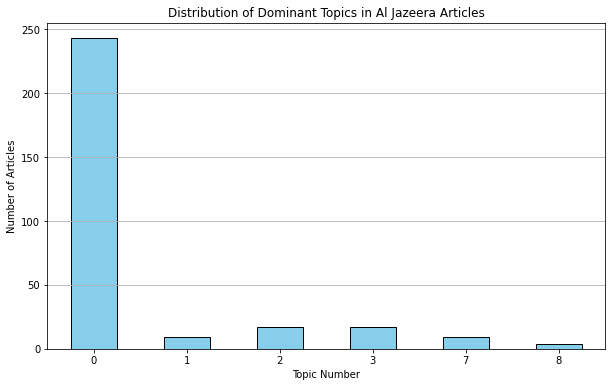

In [54]:
# Extracting the value counts for visualization
topic_counts = AlJazeera_df['dominant_topic'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
topic_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Dominant Topics in Al Jazeera Articles')
plt.xlabel('Topic Number')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

In [33]:
# Use the trained XGBoost model to predict labels
aljazeera_label = lr_model.predict(aljazeera_vectorized)

# Add the predicted labels to the Al Jazeera dataset
AlJazeera_df['label'] = aljazeera_label

In [51]:
print(AlJazeera_df[['content', 'dominant_topic', 'label']].head())

                                             content  dominant_topic  label
0  united states president joe biden lashed repub...               0      1
1  renegade general khalifa haftar, forces domina...               0      1
2  belarus claimed polish helicopter violated air...               0      0
3                                                nan               0      1
4  secretary state antony blinken meeting indian ...               0      0


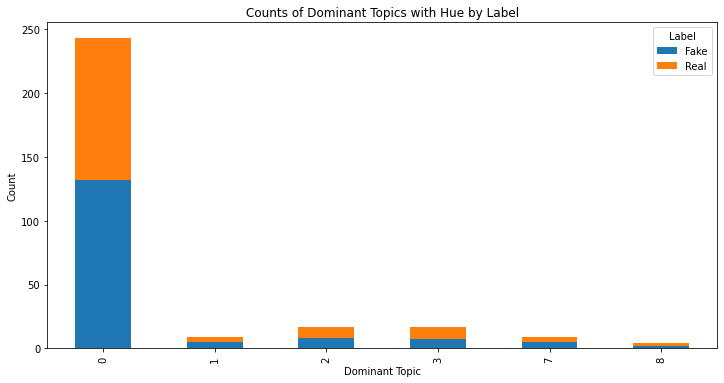

In [53]:
import matplotlib.pyplot as plt

# Assuming 'AlJazeera_df' contains the Al Jazeera dataset with predicted labels

# Group the data by dominant topic and label, and count the occurrences
grouped = AlJazeera_df.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Create a bar chart
grouped.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and a legend
plt.xlabel('Dominant Topic')
plt.ylabel('Count')
plt.title('Counts of Dominant Topics with Hue by Label')
plt.legend(title='Label', labels=['Fake', 'Real'])

# Show the plot
plt.show()


The analysis derived from the chart underscores a pivotal insight: the veracity of news articles, delineated as "real" or "fake," is not predominantly influenced by the overarching topics under which they are categorized. Instead, the authenticity of these articles is intricately tethered to the specific content they harbor — the constellation of words, phrases, and the nuanced fabric of language employed within.

This phenomenon can be attributed to several factors. Firstly, topics are broad categorizations and can encompass a wide spectrum of articles with varying degrees of credibility. For instance, a topic such as "politics" might include well-researched, factual reporting from reputable sources, as well as misleading or fabricated narratives from less credible outlets. The topic itself, being a wide umbrella, doesn't lend itself to the binary classification of news into "real" or "fake."

Conversely, the specific content within an article, the linguistic constructs and vocabulary utilized, often reveal more about its authenticity. Fake news, for example, might be more prone to sensationalist language, emotional appeals, or implausible statements, which can be identified through text analysis techniques. Moreover, the frequency and context of certain keywords can be telltale indicators of the article's intent, bias, or adherence to factual accuracy.

In essence, while topics provide a macroscopic view of news content, discerning the genuineness of news necessitates a microscopic examination of the textual content. It's within the granular details of language usage that the truthfulness of news often resides, necessitating sophisticated analytical models that probe beyond topical categorization to the heart of the written word itself.